In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd          
import numpy as np           
import matplotlib.pyplot as plt  
import seaborn as sns       
from sklearn.cluster import KMeans           
from sklearn.preprocessing import StandardScaler  
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score           
from mlxtend.frequent_patterns import apriori, association_rules
import warnings
warnings.filterwarnings("ignore")

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/global-superstore/Global Superstore.txt


# 1.1 Carregamento e Inspeção Inicial

In [18]:
df = pd.read_csv('/kaggle/input/global-superstore/Global Superstore.txt', sep='\t')

print("Visualização das primeiras linhas do Dataset: \n")
print(df.head(), "\n")

print("Visualização dos tipos de dados: \n")
print(df.info(), "\n")

print("Estatísticas numéricas: \n")
print(df.describe(), "\n")

Visualização das primeiras linhas do Dataset: 

          Category         City        Country Customer ID     Customer Name  \
0  Office Supplies  Los Angeles  United States   LS-172304  Lycoris Saunders   
1  Office Supplies  Los Angeles  United States   MV-174854     Mark Van Huff   
2  Office Supplies  Los Angeles  United States   CS-121304      Chad Sievert   
3  Office Supplies  Los Angeles  United States   CS-121304      Chad Sievert   
4  Office Supplies  Los Angeles  United States   AP-109154    Arthur Prichep   

   Discount Market  记录数               Order Date        Order ID  ... Sales  \
0       0.0     US    1  2011-01-07 00:00:00.000  CA-2011-130813  ...    19   
1       0.0     US    1  2011-01-21 00:00:00.000  CA-2011-148614  ...    19   
2       0.0     US    1  2011-08-05 00:00:00.000  CA-2011-118962  ...    21   
3       0.0     US    1  2011-08-05 00:00:00.000  CA-2011-118962  ...   111   
4       0.0     US    1  2011-09-29 00:00:00.000  CA-2011-146969  ...     6 

# 1.2 Limpeza de Dados

In [19]:
# Excluindo colunas desnecessárias, padronizando e renomeando todas as colunas

print(df.columns.tolist())
df.drop(['记录数','Row ID','Market2'], axis=1, inplace=True)

['Category', 'City', 'Country', 'Customer ID', 'Customer Name', 'Discount', 'Market', '记录数', 'Order Date', 'Order ID', 'Order Priority', 'Product ID', 'Product Name', 'Profit', 'Quantity', 'Region', 'Row ID', 'Sales', 'Segment', 'Ship Date', 'Ship Mode', 'Shipping Cost', 'State', 'Sub-Category', 'Year', 'Market2', 'weeknum']


In [20]:
df.columns = df.columns.str.strip().str.lower()

df.rename(columns={'customer id': 'customer_id', 
                   'customer name': 'customer_name', 
                   'order date': 'order_date', 
                   'order id': 'order_id', 
                   'order priority': 'order_priority', 
                   'product id': 'product_id', 
                   'product name': 'product_name', 
                   'ship date': 'ship_date', 
                   'ship mode': 'ship_mode', 
                   'shipping cost': 'shipping_cost', 
                   'sub-category': 'sub_category', 
                   'weeknum': 'week_num' }, inplace=True)

print(df.columns.tolist())

['category', 'city', 'country', 'customer_id', 'customer_name', 'discount', 'market', 'order_date', 'order_id', 'order_priority', 'product_id', 'product_name', 'profit', 'quantity', 'region', 'sales', 'segment', 'ship_date', 'ship_mode', 'shipping_cost', 'state', 'sub_category', 'year', 'week_num']


In [21]:
# a) Verificar valores nulos por coluna

df.isnull().sum()

category          0
city              0
country           0
customer_id       0
customer_name     0
discount          0
market            0
order_date        0
order_id          0
order_priority    0
product_id        0
product_name      0
profit            0
quantity          0
region            0
sales             0
segment           0
ship_date         0
ship_mode         0
shipping_cost     0
state             0
sub_category      0
year              0
week_num          0
dtype: int64


**Se uma coluna tiver poucos valores ausentes e não for essencial para a análise, removemos essas linhas, porque isso quase não afeta o resultado.Se for uma coluna importante, como Sales ou Quantity, não apagamos porque são variáveis centrais do negócio.**


In [22]:
# b) Verificar Duplicatas

duplicates = df.duplicated().sum()
print(f"Quantidade total de duplicatas: {duplicates}")

Quantidade total de duplicatas: 0


**Verifiquei se existem linhas duplicadas. Se existissem, poderiam ser removidas utilizando df.drop_duplicates().**

In [23]:
# c) Converter Datas

df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True, errors='coerce')
df['ship_date'] = pd.to_datetime(df['order_date'], dayfirst=True, errors='coerce')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   category        51290 non-null  object        
 1   city            51290 non-null  object        
 2   country         51290 non-null  object        
 3   customer_id     51290 non-null  object        
 4   customer_name   51290 non-null  object        
 5   discount        51290 non-null  float64       
 6   market          51290 non-null  object        
 7   order_date      20067 non-null  datetime64[ns]
 8   order_id        51290 non-null  object        
 9   order_priority  51290 non-null  object        
 10  product_id      51290 non-null  object        
 11  product_name    51290 non-null  object        
 12  profit          51290 non-null  float64       
 13  quantity        51290 non-null  int64         
 14  region          51290 non-null  object        
 15  sa

**Converti order_date e ship_date para o tipo datetime.**

# 1.3 Análise Exploratória (EDA)

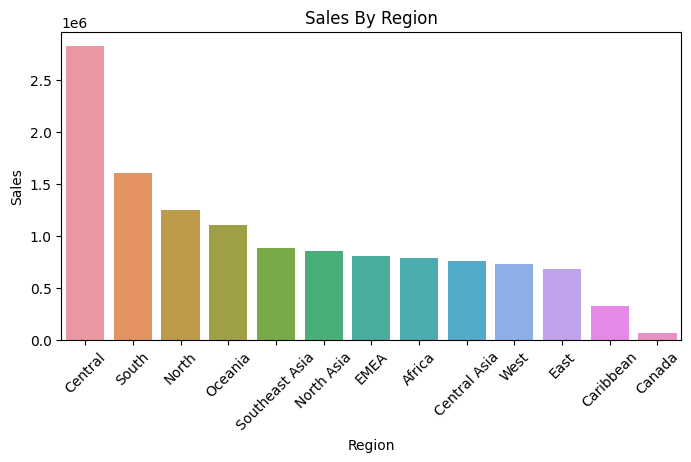

In [24]:
# a) Relação de sales por region

sales_by_region = df.groupby('region')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=sales_by_region.index, y=sales_by_region.values)
plt.title("Sales By Region")
plt.xlabel("Region")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.show()

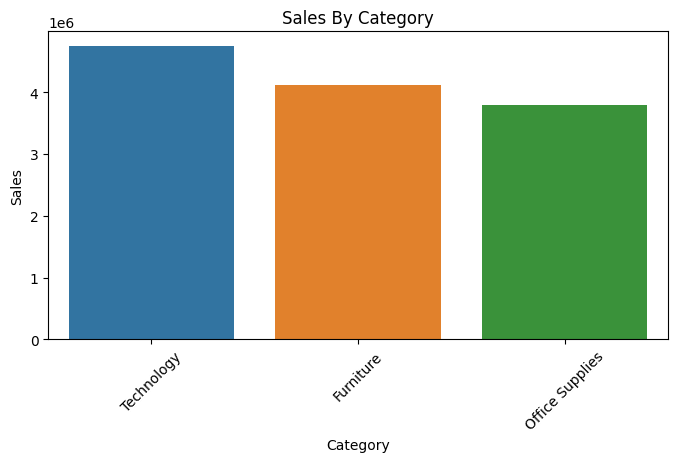

In [25]:
# b) Relação de sales por category

sales_by_category = df.groupby('category')['sales'].sum().sort_values(ascending=False)

plt.figure(figsize=(8,4))
sns.barplot(x=sales_by_category.index, y=sales_by_category.values)
plt.title("Sales By Category")
plt.xlabel("Category")
plt.ylabel("Sales")
plt.xticks(rotation=45)
plt.show()

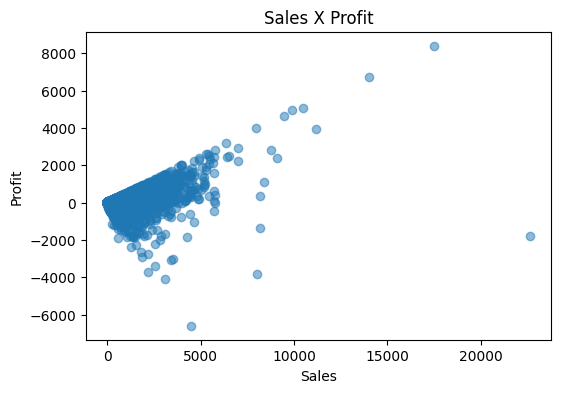

In [26]:
# c) Relação de sales e profit

plt.figure(figsize=(6,4))
plt.scatter(df['sales'], df['profit'], alpha=0.5)
plt.title("Sales X Profit")
plt.xlabel("Sales")
plt.ylabel("Profit")
plt.show()

In [27]:
# d) Quais sub_categories mais e menos vendidas?

subcat_sales = df.groupby('sub_category')['sales'].sum().sort_values(ascending=False)
subcat_qty = df.groupby('sub_category')['quantity'].sum().sort_values(ascending=False)

print(f"Quantidade de receita das sub_categories: \n{subcat_sales.head(),subcat_sales.tail() } \n")
print(f"Quantidade de vendas das sub_categories: \n{subcat_qty.head(),subcat_qty.tail() }")

Quantidade de receita das sub_categories: 
(sub_category
Phones       1706874
Copiers      1509439
Chairs       1501682
Bookcases    1466559
Storage      1127124
Name: sales, dtype: int64, sub_category
Paper        244307
Supplies     243090
Envelopes    170926
Fasteners     83254
Labels        73433
Name: sales, dtype: int64) 

Quantidade de vendas das sub_categories: 
(sub_category
Binders    21429
Storage    16917
Art        16301
Paper      12822
Chairs     12336
Name: quantity, dtype: int64, sub_category
Bookcases     8310
Copiers       7454
Appliances    6078
Machines      4906
Tables        3083
Name: quantity, dtype: int64)


**Aqui, identifiquei quais subcategorias mais geram receita (soma de sales) e quais mais saem em volume de unidades (quantity).
Observa-se que a sub_category "Phone" é a mais vendida e a "Tables" é a menos vendida.**

# 2.1 Segmentação de Clientes (k-means)

In [28]:
# Preparar dados de cliente

cols_for_group = ['customer_id', 'sales', 'profit']

client_df = df[cols_for_group].groupby('customer_id').sum()

client_df.head()

,sales,profit
customer_id,,
AA-103151,1445,12.8760
AA-103152,6105,568.7370
AA-103153,633,228.9600
AA-103154,5565,-362.8825
AA-103751,2407,577.9350


**Aqui eu crio uma tabela para ter uma visão por cliente. Cada linha representa um com o total que ele comprou e o lucro associado, caso exista.**

# 2.2 Normalizar os Dados e Método do Cotovelo (Elbow Method)

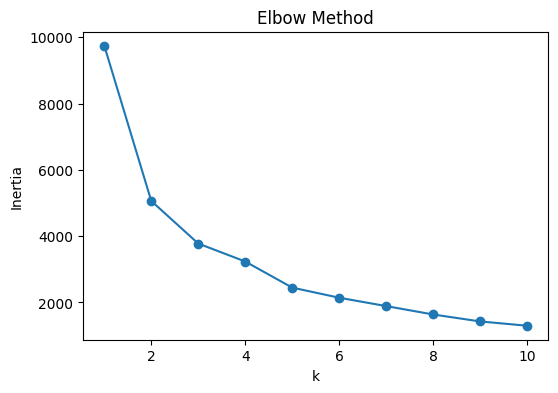

In [29]:
# Elbow Method

scaler = StandardScaler()
client_scaled = scaler.fit_transform(client_df)

inertia_values = []
K_range = range(1,11)

for k in K_range:
    kmeans_tmp = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans_tmp.fit(client_scaled)
    inertia_values.append(kmeans_tmp.inertia_)

plt.figure(figsize=(6,4))
plt.plot(K_range, inertia_values, marker='o')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

**O Elbow Method mede a inércia, que significa o quao bem os pontos ficam próximos do centro. Testei vários valores de K e procuro onde a curva começa a ficar mais achatada. Como podemos ver no gráfico, é entre K=3 e K=4**

# 2.3 K-means Definitivo

In [30]:
k_final = 3

kmeans = KMeans(n_clusters=k_final, random_state=42, n_init='auto')
client_clusters = kmeans.fit_predict(client_scaled)

client_df['cluster'] = client_clusters
client_df.head()

,sales,profit,cluster
customer_id,,,
AA-103151,1445,12.8760,0
AA-103152,6105,568.7370,1
AA-103153,633,228.9600,0
AA-103154,5565,-362.8825,1
AA-103751,2407,577.9350,1


**Depois de ter escolhido K pelo cotovelo, eu treino o K-means final e adiciono a coluna cluster ao dataframe, indicando qual grupo cada cliente pertence**

# 2.4 Visualizar e Interpretar Clusters

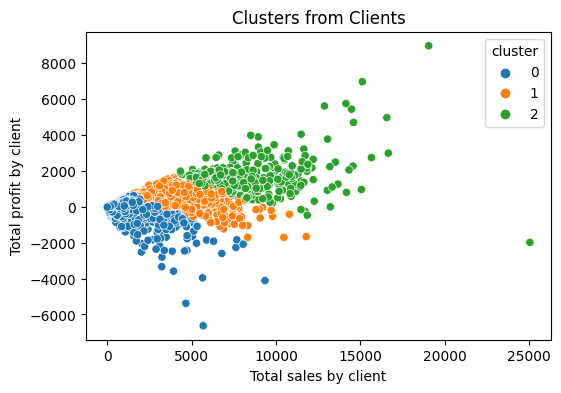

In [31]:
plt.figure(figsize=(6,4))
sns.scatterplot(x=client_df['sales'],
                y=client_df['profit'],
                hue=client_df['cluster'],
                palette='tab10')
plt.xlabel('Total sales by client')
plt.ylabel('Total profit by client')
plt.title('Clusters from Clients')
plt.show()

**Aqui, fica mas fácil de identificar os clusters e os tipos de clientes que temos:
->Cluster 0: Clientes com alto volume de compras e alto lucro -> “clientes de alto valor”.
->Cluster 1: Clientes que compram bastante mas geram pouco lucro -> pode indicar desconto alto ou produtos de baixa margem.
->Cluster 2: Clientes de baixo gasto total -> clientes ocasionais.**

# 3.1 Análise de Cesta de Compras com Regras de Associação

In [47]:
basket = (df.groupby(['order_id', 'sub_category'])['quantity'].sum().unstack().fillna(0))
basket_binary = basket.applymap(lambda x: 1 if x > 0 else 0)

basket_binary.head()

sub_category,Accessories,Appliances,Art,Binders,Bookcases,Chairs,Copiers,Envelopes,Fasteners,Furnishings,Labels,Machines,Paper,Phones,Storage,Supplies,Tables
order_id,,,,,,,,,,,,,,,,,
AE-2011-9160,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
AE-2013-1130,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
AE-2013-1530,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0
AE-2014-2840,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
AE-2014-3830,0,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0


**Aqui eu transformo os dados no formato de “cesta de compras”: 
Cada linha é um pedido, cada coluna é um produto.
Valor 1 significa que aquele produto fez parte daquele pedido.**

# 3.2 Apriori e Itemsets Frequentes

In [64]:
freq_items = apriori(basket_binary, min_support=0.01, use_colnames=True)
freq_items.sort_values(by='support', ascending=False).head()

,support,itemsets
3,0.215378,(Binders)
14,0.181106,(Storage)
2,0.174396,(Art)
12,0.129179,(Paper)
5,0.127302,(Chairs)


**Aqui eu usei min_support=0.01, ou seja, só considero combinações que aparecem em pelo menos 1% dos pedidos.
Foi o min_support que eu achei que deu o melhor resultado.**

# 3.3 Regras de Associação

In [65]:
rules = association_rules(freq_items, metric='confidence', min_threshold=0.05)
strong_rules = rules[rules['lift'] > 1].sort_values(by='lift', ascending=False)

strong_rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
22,(Appliances),(Paper),0.067346,0.129179,0.010106,0.150059,1.161637,1.0,0.001406,1.024567,0.149194,0.054210,0.023978,0.114145
23,(Paper),(Appliances),0.129179,0.067346,0.010106,0.078231,1.161637,1.0,0.001406,1.011809,0.159787,0.054210,0.011672,0.114145
20,(Appliances),(Binders),0.067346,0.215378,0.015618,0.231910,1.076755,1.0,0.001113,1.021523,0.076431,0.058472,0.021069,0.152212
21,(Binders),(Appliances),0.215378,0.067346,0.015618,0.072515,1.076755,1.0,0.001113,1.005573,0.090851,0.058472,0.005542,0.152212
42,(Machines),(Art),0.056800,0.174396,0.010665,0.187764,1.076652,1.0,0.000759,1.016458,0.075483,0.048361,0.016192,0.124459


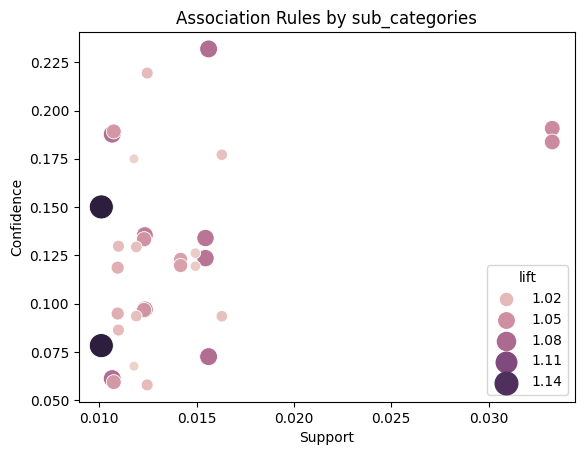

In [66]:
sns.scatterplot(data=strong_rules, x='support', y='confidence', size='lift', hue='lift', sizes=(50,300))
plt.title('Association Rules by sub_categories')
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.show()

**Depois de ajustar o nível de análise para sub_category, o algoritmo foi capaz de identificar padrões de compra mais consistentes.
As categorias “Binders”, “Storage” e “Art” se destacaram como as mais frequentes nas transações, e dá pra ver uma correlação leve entre “Art” e “Storage”, com lift próximo de 1.05, indicando que há uma tendência moderada de compra conjunta.**

# 3.4 Interpretar as 5 Melhores Regras

In [67]:
top5 = strong_rules.head(5)
top5[['antecedents', 'consequents', 'support', 'confidence', 'lift']]


,antecedents,consequents,support,confidence,lift
22,(Appliances),(Paper),0.010106,0.150059,1.161637
23,(Paper),(Appliances),0.010106,0.078231,1.161637
20,(Appliances),(Binders),0.015618,0.231910,1.076755
21,(Binders),(Appliances),0.015618,0.072515,1.076755
42,(Machines),(Art),0.010665,0.187764,1.076652


**As associações que identifiquei demonstram que as categorias de produtos relacionadas a equipamentos e materiais de escritório tendem a ser compradas em conjunto.
Apesar de a força das regras ser modesta, evidencia padrões de coocorrência típicos de ambientes corporativos, como a compra conjunta de suprimentos (Paper, Binders) e equipamentos (Appliances, Machines).**

# 4.1 Previsão de Vendas

In [70]:
X = df[['quantity']]  
y = df['sales']        

model = LinearRegression()
model.fit(X, y)

coeficient = model.coef_[0]
intercept = model.intercept_

coeficient, intercept

(67.09389439683196, 13.243488054437535)

**A equação encontrada pelo modelo é:
Sales = m * Quantity + b.
Onde
m (inclinação) = 67.09389439683196
b (intercepto) = 13.243488054437535**

# 4.2 Avaliação Visual do Modelo

In [72]:
y_pred = model.predict(X)
r2 = r2_score(y, y_pred)
r2

0.09833240584253866

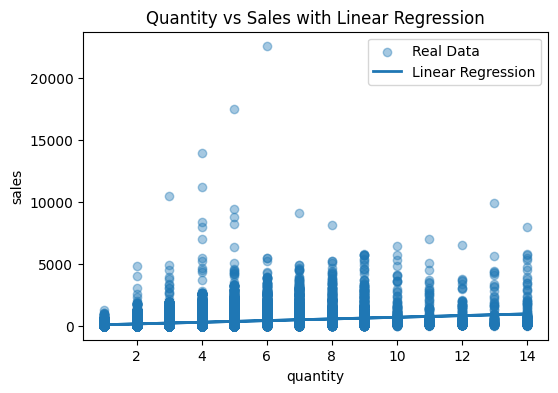

In [74]:
plt.figure(figsize=(6,4))
plt.scatter(X['quantity'], y, alpha=0.4, label='Real Data')
plt.plot(X['quantity'], y_pred, linewidth=2, label='Linear Regression')
plt.xlabel('quantity')
plt.ylabel('sales')
plt.title('Quantity vs Sales with Linear Regression')
plt.legend()
plt.show()

**Esse gráfico de dispersão com a linha de regressão por cima mostra se a reta está conseguindo seguir a tendência geral dos pontos.
Também calculo o R² para ver quanto da variação de Sales é explicada só por Quantity. Como o R² é baixo, isso significa que só a quantidade não explica tudo sobre o valor vendido (pode depender de desconto, tipo de produto, etc.).**

# 5.1 Detecção de Anomalias

In [75]:
Q1 = df['sales'].quantile(0.25)
Q3 = df['sales'].quantile(0.75)
IQR = Q3 - Q1

lower_limit = Q1 - 1.5 * IQR
upper_limit = Q3 + 1.5 * IQR

outliers_sales = df[(df['sales'] < lower_limit) | (df['sales'] > upper_limit)]

len_outliers_sales = len(outliers_sales)
outliers_sales.head()
len_outliers_sales

5655

**Aqui eu aplico o método do Intervalo Interquartil (IQR) para detectar vendas extremamente baixas ou extremamente altas e mostro a quantidade.**

# 5.2 Outliers de Profit usando Z-Score

In [77]:
profit_mean = df['profit'].mean()
profit_std = df['profit'].std()

df['profit_z'] = (df['profit'] - profit_mean) / profit_std

outliers_profit = df[np.abs(df['profit_z']) >= 3]

len_outliers_profit = len(outliers_profit)
outliers_profit.head()
len_outliers_profit

865

**O Z-Score mede quantos desvios padrão cada valor está distante da média.
Valores com |Z| ≥ 3 são considerados muito fora do padrão, logo possíveis anomalias (lucro muito alto, prejuízo muito grande etc.).
Eu conto quantas linhas caem nessa categoria.**

In [81]:
outliers_profit.head()

,category,city,country,customer_id,customer_name,discount,market,order_date,order_id,order_priority,...,sales,segment,ship_date,ship_mode,shipping_cost,state,sub_category,year,week_num,profit_z
803,Office Supplies,Brentwood,United States,RW-195404,Rick Wilson,0.0,US,NaT,CA-2014-166093,Medium,...,2518,Corporate,NaT,Standard Class,173.07,California,Appliances,2014,34,3.591493
1137,Office Supplies,New York City,United States,JD-161504,Justin Deggeller,0.0,US,NaT,CA-2014-168858,High,...,2505,Corporate,NaT,Standard Class,235.83,New York,Appliances,2014,47,3.427617
1742,Office Supplies,Newark,United States,YC-218954,Yoseph Carroll,0.0,US,NaT,CA-2011-119375,High,...,2934,Corporate,NaT,Standard Class,428.80,Delaware,Storage,2011,47,4.380256
1757,Office Supplies,Columbia,United States,PW-192404,Pierre Wener,0.0,US,NaT,CA-2012-162782,Medium,...,2542,Consumer,NaT,Standard Class,91.36,Maryland,Binders,2012,8,7.126145
1866,Office Supplies,Providence,United States,DB-132704,Deborah Brumfield,0.0,US,2013-03-12,CA-2013-163804,Medium,...,2079,Home Office,2013-03-12,Standard Class,101.18,Rhode Island,Storage,2013,49,3.175507


In [82]:
positive_profits = len(outliers_profit[outliers_profit['profit'] > 0])
negative_losses = len(outliers_profit[outliers_profit['profit'] < 0])

positive_profits, negative_losses

(578, 287)

**Dos 865 registros identificados como anômalos pelo método do Z-Score, foi possível observar que:
578 correspondem a lucros anormais - vendas com lucro muito acima do padrão médio;
287 correspondem a prejuízos anormais - transações com perdas elevadas.
Esses resultados mostram que o dataset apresenta tanto picos de lucratividade extrema (possivelmente grandes contratos ou vendas corporativas) quanto situações de prejuízo significativo, que podem ter origem em custos logísticos altos, devoluções, ou descontos exagerados.**

# 5.3 Discussão Final

O método do IQR em Sales destacou vendas extremamente altas. Essas vendas podem representar pedidos corporativos grandes, negociações especiais ou até possíveis erros de lançamento (por exemplo, digitar um zero a mais).

O método de Z-Score em Profit destacou pontos onde o lucro foi muito acima ou muito abaixo do esperado. Lucros muito negativos podem indicar que a loja vendeu com prejuízo (talvez por desconto agressivo ou custo de frete alto).

Qual método pareceu mais útil?

Se o negócio quer monitorar vendas fora da curva (pedidos gigantes), IQR em Sales é direto.

Se o foco é entender problemas de margem (por que estamos perdendo dinheiro em certos pedidos?), então o Z-Score em Profit é mais informativo.

Essas anomalias são importantes porque podem indicar:
oportunidades VIP (clientes que compram muito acima da média), risco de fraude, erro de cadastro, políticas de desconto que estão matando o lucro.